<a href="https://colab.research.google.com/github/nicolas-chaulet/torch-points3d/blob/modelnettuto/dashboard/ObjectClassificationRSConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Setup packages
!pip install torch==1.3.1 pyvista torchvision==0.4.2
!pip install --upgrade jsonschema
!pip install git+git://github.com/nicolas-chaulet/torch-points3d.git@modelnet
!apt-get install -qq xvfb

     |████████████████████████████████| 734.6MB 23kB/s 
     |████████████████████████████████| 1.2MB 48.4MB/s 
     |████████████████████████████████| 10.2MB 36.0MB/s 
     |████████████████████████████████| 133kB 41.1MB/s 
     |████████████████████████████████| 48.9MB 60kB/s 
  Created wheel for pyvista: filename=pyvista-0.24.2-cp36-none-any.whl size=1170778 sha256=430018d7ac740a3f864df04a473b8894b05b643b32b43b67204fd288d3a5cf34
  Stored in directory: /root/.cache/pip/wheels/2e/a5/b2/28c5f96974778446676a0500504e9685abf3f6d1383ba7c96d
  Created wheel for scooby: filename=scooby-0.5.4-cp36-none-any.whl size=13458 sha256=29b650414cd08e251f6be5d5acab2f24721c26f1b6e7721f9e647537eb26f77b
  Stored in directory: /root/.cache/pip/wheels/77/a4/93/3b8e158b48b2d44d20792760b060c3fa91aae64e5e428bcac6
Successfully built pyvista scooby
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: 

In [0]:
# Needed for remote rendering 
import os
os.system('export DISPLAY=:99.0 \
export PYVISTA_OFF_SCREEN=true \
export PYVISTA_USE_PANEL=true \
export PYVISTA_PLOT_THEME=document \
# This is needed for Panel - use with cuation!\
export PYVISTA_AUTO_CLOSE=false \
which Xvfb \
Xvfb :99 -screen 0 1024x768x24 > /dev/null 2>&1 & \
sleep 3 \
exec "$@"')

In [0]:
import os
import sys
from omegaconf import OmegaConf
import pyvista as pv
import torch

In [0]:
DIR = "" # Replace with your root directory.

<p align="center">
  <img width="40%" src="https://raw.githubusercontent.com/nicolas-chaulet/torch-points3d/master/docs/logo.png" />
</p>


# Classifiying objects with Relation-Shape CNN
This notebook explains how Torch Points3D can be used to solve an object classification task. We will use [ModelNet](https://modelnet.cs.princeton.edu/) as our dataset and [Relation-Shape CNN](https://github.com/Yochengliu/Relation-Shape-CNN) as our model architecture. The dataset contains CAD models of objects that belong to 40 different categories and the task is to retrieve the category of the object from its point cloud representation. There is also a smaller version well suited for quick testing that contains only 10 classes. The notebook covers the following aspects of Torch Points3D:

1. Create a dataset with a data augmentation pipeline
2. Instantiate a pre configured model
3. Setup the data loaders
4. Run a training


In [0]:
MODELNET_VERSION="40"

## The dataset
We will use Torch Points3D to download and create the dataset. It automatically downloads a pre sampled version of ModelNet (with 10,000 points per object) and the data will be stored under the `ROOT/data/modelnet` directory. Creating the raw dataset is as simple as:

In [64]:
from torch_points3d.datasets.classification.modelnet import SampledModelNet
import torch_points3d.core.data_transform as T3D
import torch_geometric.transforms as T

dataroot = os.path.join(DIR, "data/modelnet")
pre_transform = T.Compose([T.NormalizeScale(), T3D.GridSampling(0.02)])
dataset = SampledModelNet(dataroot, name=MODELNET_VERSION, train=True, transform=None,
                 pre_transform=pre_transform, pre_filter=None)
dataset[0]

Processing...
Done!


Data(norm=[5672, 3], pos=[5672, 3], y=[1])

Each sample is a CAD model of an object (bathtub, toilet, bed, etc...), the `pos` attribute contains the coordinates of points sampled on each face of the mesh while `norm` contains the normal vector. You will notice that we have applied two pre transforms to our dataset:

- `NormalizeScale` normalises the scale of each object
- `GridSampling` does a voxel downsizing of each point cloud with a resolution of 0.02 (in normalized scale). This ensures that we don't have really dense areas.

Let's visualise some of those examples before going any further.


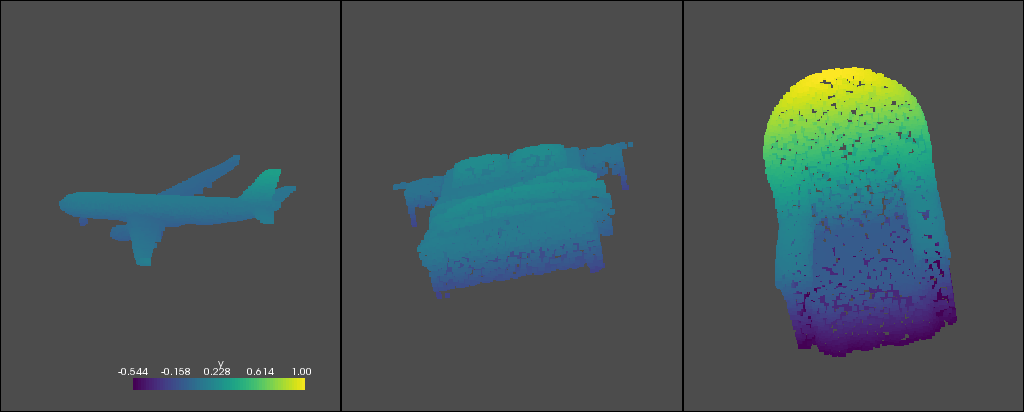

In [65]:
samples = [10,1000,3000]
p = pv.Plotter(notebook=True,shape=(1, len(samples)),window_size=[1024,412])

for i in range(len(samples)):
    p.subplot(0, i)
    sample = dataset[samples[i]].pos.numpy()
    point_cloud = pv.PolyData(sample)
    point_cloud['y'] = sample[:,1]
    p.add_points(point_cloud)
    p.camera_position = [-1,5, -10]
p.show()

## Building a model
As mentioned in the introduction we will use Relation-Shape CNN as our backbone architecture for the model classifier. Let's build our model by using Torch Points3D API (you can ignore the error, it comes from a third party library and all works just fine). We will use the normal vector as an input feature, therefore we will set the number of input channels (`input_nc`) to 3.

In [0]:
from torch_points3d.applications.rsconv import RSConv

In [0]:
class RSConvCLassifier(torch.nn.Module):
    def __init__(self):
        super().__init__() 
        self.encoder = RSConv("encoder", input_nc=3,output_nc = int(MODELNET_VERSION), num_layers=4)
        self.log_softmax = torch.nn.LogSoftmax(dim=-1)
    
    @property
    def conv_type(self):
        """ This is needed by the dataset to infer which batch collate should be used"""
        return self.encoder.conv_type
    
    def get_output(self):
        """ This is needed by the tracker to get access to the ouputs of the network"""
        return self.output
    
    def get_labels(self):
        """ Needed by the tracker in order to access ground truth labels"""
        return self.labels
    
    def get_current_losses(self):
        """ Entry point for the tracker to grab the loss """
        return {"loss_class": float(self.loss_class)}
    
    def forward(self, data):
        # Set labels for the tracker
        self.labels = data.y.squeeze()

        # Forward through the network
        data_out = self.encoder(data)
        self.output = self.log_softmax(data_out.x.squeeze())

        # Set loss for the backward pass
        self.loss_class = torch.nn.functional.nll_loss(self.output, self.labels)
    
    def backward(self):
         self.loss_class.backward()    
        

In [46]:
model = RSConvCLassifier()

## Setting up the data loaders
In this section, we will first build  a data loader using basic building blocks, and then we will see how one can use our dataset wrapper to assemble a dataset ready for training with its test and train data loader configured.

Let's start with a vanillia data loader. There are two ways to assemble batches depending on the model that is used. In that case we will want dense batches where samples are concatenated along the first dimension, just like for batches of images. It is very important to ensure that each sample has got the same number of points, this can be achieved by applying a `FixedPoints` transform to the dataset. here we will use 2048 points per object.

In [68]:
from torch_points3d.datasets.batch import SimpleBatch
NUM_WORKERS = 4
BATCH_SIZE = 12

transform = T.FixedPoints(2048)
dataset = SampledModelNet(dataroot, name=MODELNET_VERSION, train=True, transform=transform,
                 pre_transform=pre_transform, pre_filter=None)

collate_function = lambda datalist: SimpleBatch.from_data_list(datalist)
train_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,  
    collate_fn=collate_function
)
next(iter(train_loader))

SimpleBatch(norm=[12, 2048, 3], pos=[12, 2048, 3], y=[12, 1])

If we were using a model that can handle packed data we would not need the `FixedPoints` transform at all and each object could have a different number of points.

In [0]:
from torch_geometric.data import Batch

dataset = SampledModelNet(dataroot, name=MODELNET_VERSION, train=True, transform=None,
                 pre_transform=pre_transform, pre_filter=None)

collate_function = lambda datalist: Batch.from_data_list(datalist)
train_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,  
    collate_fn=collate_function
)
next(iter(train_loader))

We also provide a higher level interface that builds the train and test data loaders for you based on which model you use. We use an OmegaConf config to instantiate it (or any object with a similar interface). The config must contain the arguments required by the dataset. We can also include the pre transforms, test transforms and train transforms. The transform pipeline will look like this:

1. Sample a fixed number of points
2. Add random noise to the positions
3. Randomly rotate the point cloud around the z axis
4. Add the normal vector to the features getting into the network

The config will be as follow:

In [0]:
yaml_config = """
task: classification
class: modelnet.ModelNetDataset
name: modelnet
dataroot: {}
number: {}
pre_transforms:
    - transform: NormalizeScale
    - transform: GridSampling
      lparams: [0.02]
train_transforms:
    - transform: FixedPoints
      lparams: [2048]
    - transform: RandomNoise
    - transform: RandomRotate
      params:
        degrees: 180
        axis: 2
    - transform: AddFeatsByKeys
      params:
        feat_names: [norm]
        list_add_to_x: [True]
        delete_feats: [True]
test_transforms:
    - transform: FixedPoints
      lparams: [2048]
    - transform: AddFeatsByKeys
      params:
        feat_names: [norm]
        list_add_to_x: [True]
        delete_feats: [True]
""".format(os.path.join(DIR, "data"),MODELNET_VERSION)

from omegaconf import OmegaConf
params = OmegaConf.create(yaml_config)

In [50]:
from torch_points3d.datasets.classification.modelnet import ModelNetDataset
dataset = ModelNetDataset(params)
dataset

/usr/local/lib/python3.6/dist-packages/torch_geometric/data/dataset.py:94: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you really want to make use of another pre-processing technique, make sure to delete `data/modelnet/processed/processed` first.
  self.processed_dir))


Dataset: ModelNetDataset 
pre_transform = Compose([
    NormalizeScale(),
    GridSampling(grid_size=0.02, quantize_coords=False, mode=mean),
    FixedPoints(2048, replace=True),
    AddFeatsByKeys(norm=True),
])
test_transform = Compose([
    FixedPoints(2048, replace=True),
    AddFeatsByKeys(norm=True),
])
train_transform = Compose([
    FixedPoints(2048, replace=True),
    RandomNoise(sigma=0.01, clip=0.05),
    RandomRotate((-180, 180), axis=2),
    AddFeatsByKeys(norm=True),
])
val_transform = None
inference_transform = Compose([
    NormalizeScale(),
    GridSampling(grid_size=0.02, quantize_coords=False, mode=mean),
    FixedPoints(2048, replace=True),
    AddFeatsByKeys(norm=True),
])
Size of train_dataset = 3991
Size of test_dataset = 908
Size of val_dataset = 0
Batch size = None

We can see here that the train and test transforms have been set properly. The batch size is still not set since the data loaders have not been instantiaded yet, let's do that now and we will have a dataset ready for training. We can also instantiate the tracker directly from the dataset which reduces potential risks in using the wrong metrics.

In [0]:
dataset.create_dataloaders(
    model, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS, 
    precompute_multi_scale=False
)

In [17]:
next(iter(dataset.test_dataloaders[0]))

SimpleBatch(pos=[12, 2048, 3], x=[12, 2048, 3], y=[12, 1])

In [52]:
tracker = dataset.get_tracker(False, False)
tracker

## Training!
We can now start our training loop, we will use the Adam optimizer with a learning rate of 0.01.

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [0]:
from torch_points3d.metrics.colored_tqdm import Coloredtqdm as Ctq
import time

def train_epoch(device):
    model.to(device)
    model.train()
    tracker.reset("train")
    train_loader = dataset.train_dataloader
    iter_data_time = time.time()
    with Ctq(train_loader) as tq_train_loader:
        for i, data in enumerate(tq_train_loader):
            t_data = time.time() - iter_data_time
            iter_start_time = time.time()
            optimizer.zero_grad()
            data.to(device)
            model.forward(data)
            model.backward()
            optimizer.step()
            if i % 10 == 0:
                tracker.track(model)

            tq_train_loader.set_postfix(
                **tracker.get_metrics(),
                data_loading=float(t_data),
                iteration=float(time.time() - iter_start_time),
            )
            iter_data_time = time.time()

def test_epoch(device):
    model.to(device)
    model.eval()
    tracker.reset("test")
    test_loader = dataset.test_dataloaders[0]
    iter_data_time = time.time()
    with Ctq(test_loader) as tq_test_loader:
        for i, data in enumerate(tq_test_loader):
            t_data = time.time() - iter_data_time
            iter_start_time = time.time()
            data.to(device)
            model.forward(data)           
            tracker.track(model)

            tq_test_loader.set_postfix(
                **tracker.get_metrics(),
                data_loading=float(t_data),
                iteration=float(time.time() - iter_start_time),
            )
            iter_data_time = time.time()

In [63]:
EPOCHS = 50
for i in range(50):
  print("=========== EPOCH %i ===========" % i)
  time.sleep(0.5)
  train_epoch('cuda')
  test_epoch('cuda')

=========== EPOCH 0 ===========


100%|██████████| 76/76 [00:15<00:00,  4.87it/s, data_loading=0.003, iteration=0.128, test_acc=86.95, test_loss_class=0.379]


=========== EPOCH 1 ===========


100%|██████████| 76/76 [00:15<00:00,  4.91it/s, data_loading=0.003, iteration=0.132, test_acc=88.15, test_loss_class=0.368]


=========== EPOCH 2 ===========


100%|██████████| 76/76 [00:15<00:00,  4.91it/s, data_loading=0.003, iteration=0.13 , test_acc=89.14, test_loss_class=0.317]


=========== EPOCH 3 ===========


100%|██████████| 76/76 [00:15<00:00,  4.92it/s, data_loading=0.004, iteration=0.129, test_acc=88.92, test_loss_class=0.357]


=========== EPOCH 4 ===========


100%|██████████| 76/76 [00:15<00:00,  4.88it/s, data_loading=0.010, iteration=0.129, test_acc=90.46, test_loss_class=0.293]


=========== EPOCH 5 ===========


100%|██████████| 76/76 [00:15<00:00,  4.90it/s, data_loading=0.003, iteration=0.130, test_acc=88.92, test_loss_class=0.317]


=========== EPOCH 6 ===========


100%|██████████| 76/76 [00:15<00:00,  4.87it/s, data_loading=0.005, iteration=0.131, test_acc=89.80, test_loss_class=0.312]


=========== EPOCH 7 ===========


 28%|██▊       | 93/333 [00:45<01:57,  2.05it/s, data_loading=0.004, iteration=0.475, train_acc=91.66, train_loss_class=0.357]


KeyboardInterrupt: ignored